# ✅ 11주차 복습과제: Word2Vec 복습과 RNN/CNN을 이용한 Sentence Classification
- 이번 복습과제는 다음과 같이 이루어져있습니다.
  1. Word2Vec 복습 (VanillaSkipGram)
  2. RNN으로 문장 분류
  3. CNN으로 문장 분류

### **1. Word2Vec Skip-gram 모델 구현**

In [6]:
#라이브러리 임포트
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import defaultdict
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [7]:
#corpus(말뭉치) 만들기 -> 직접 새로운 말뭉치를 만들어봐도 좋습니다!
corpus = [
    "he likes cat", "she likes dog", "dog barks", "cat meows",
    "he walks the dog", "she feeds the cat", "the cat sleeps on the sofa",
    "the dog plays in the yard", "they both like animals", "animals are friends",
    "cats are cute", "dogs are the best", "she plays with the cat", "she is not afraid of animals"
]

In [8]:
# 단어 사전 구축
word_list = set(" ".join(corpus).split())
word_to_ix = {word: i for i, word in enumerate(word_list)}
ix_to_word = {i: word for word, i in word_to_ix.items()}
vocab_size = len(word_to_ix)

In [9]:
# context-target 쌍 만들기
def make_context_target(corpus, window_size=1):
    pairs = []
    for sentence in corpus:
        words = sentence.split()
        for i, word in enumerate(words):
            for j in range(max(i - window_size, 0), min(i + window_size + 1, len(words))):
                if i != j:
                    pairs.append((word, words[j]))
    return pairs

pairs = make_context_target(corpus)

def word_to_tensor(word):
    return torch.tensor([word_to_ix[word]], dtype=torch.long)

In [10]:
#VanillaSkipgram 정의
class VanillaSkipgram(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, input_ids):
        embeddings = self.embedding(input_ids)
        output = self.linear(embeddings)
        return output

In [11]:
#Cross Entropy Loss, Adam Optimizer(learning rate = 0.01)를 사용하세요
embedding_dim = 10
model = VanillaSkipgram(vocab_size, embedding_dim)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [13]:
for epoch in range(200):
    total_loss = 0
    for center, context in pairs:
        center_tensor = word_to_tensor(center)
        context_tensor = word_to_tensor(context)
        optimizer.zero_grad()
        outputs = model(center_tensor)
        loss = criterion(outputs, context_tensor)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 20, Loss: 113.1881
Epoch 40, Loss: 109.5974
Epoch 60, Loss: 108.2708
Epoch 80, Loss: 107.4799
Epoch 100, Loss: 106.9118
Epoch 120, Loss: 106.4672
Epoch 140, Loss: 106.1015
Epoch 160, Loss: 105.7963
Epoch 180, Loss: 105.5266
Epoch 200, Loss: 105.2929


In [14]:
# 결과 확인
word = "dog"  #다른 단어로 바꿔서 확인해볼 수도 있습니다
word_tensor = word_to_tensor(word)
embedding = model.embedding(word_tensor)
print(f"'{word}'의 임베딩 벡터:")
print(embedding)

'dog'의 임베딩 벡터:
tensor([[-0.4763,  0.2239,  1.1486, -0.0129, -1.0528,  0.0066,  0.0833, -0.1416,
         -1.7379,  0.9250]], grad_fn=<EmbeddingBackward0>)


In [15]:
#시각화하기
embedding_matrix = model.embedding.weight.data.cpu().numpy()

words = list(word_to_ix.keys())[:20]
vectors = np.array([embedding_matrix[word_to_ix[word]] for word in words])

tsne = TSNE(n_components=2, perplexity=5, max_iter=300, random_state=0)
reduced = tsne.fit_transform(vectors)

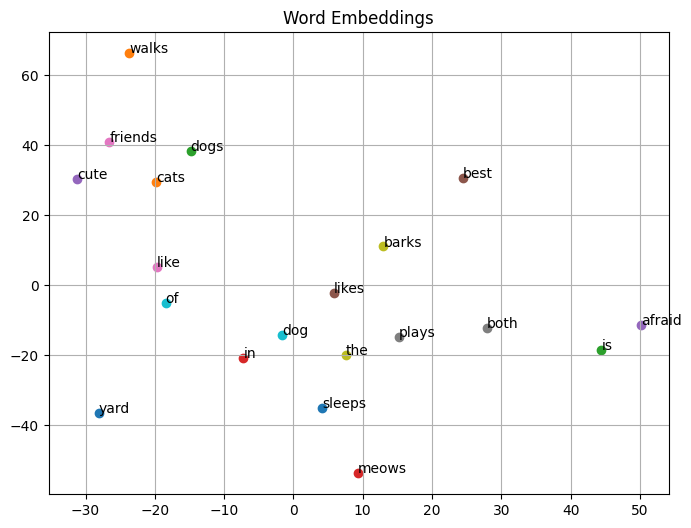

In [16]:
plt.figure(figsize=(8, 6))
for i, word in enumerate(words):
    x, y = reduced[i]
    plt.scatter(x, y)
    plt.text(x + 0.01, y + 0.01, word, fontsize=10)
plt.title("Word Embeddings")
plt.grid(True)
plt.show()

### **2. RNN을 활용한 문장 분류 모델 구현**

In [17]:
import torch.nn.functional as F

In [18]:
train_data = [
    ("I love this movie", 1),
    ("This film is terrible", 0),
    ("I enjoyed it", 1),
    ("Not good", 0),
    ("This movie was fantastic and inspiring", 1),
    ("Absolutely horrible experience", 0),
    ("What a wonderful story and cast", 1),
    ("The plot was dull and boring", 0),
    ("A truly uplifting journey", 1),
    ("It was a waste of time", 0),
    ("I think they could have done better", 0),
    ("It was really enjoyable", 1),
    ("This became my favorite movie", 1),
    ("I recommended this to all of my friends", 1),
    ("My son could film a better movie than this", 0),
    ("It was underwhelming", 0)
]

In [20]:
# 단어 사전
word_set = set()
for sent, _ in train_data:
    for word in sent.lower().split():
        word_set.add(word)

word_to_ix = {word: i+1 for i, word in enumerate(word_set)}  # 0: padding
vocab_size = len(word_to_ix) + 1

def encode_sentence(sent, max_len=10):
    tokens = [word_to_ix.get(word, 0) for word in sent.lower().split()]
    tokens += [0] * (max_len - len(tokens))
    return torch.tensor(tokens[:max_len])

X = torch.stack([encode_sentence(s) for s, _ in train_data])
y = torch.tensor([label for _, label in train_data])

In [22]:
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 2)

    def forward(self, inputs):
        embeddings = self.embedding(inputs)
        output, _ = self.rnn(embeddings)
        return self.fc(_.squeeze(0))

In [23]:
model = RNNClassifier(vocab_size, embedding_dim=16, hidden_dim=32)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(30):
    optimizer.zero_grad()
    outputs = model(X)
    loss = loss_fn(outputs, y)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

preds = torch.argmax(model(X), dim=1)
print("예측 결과:", preds.tolist())
print("실제 정답:", y.tolist())


Epoch 10, Loss: 0.0219
Epoch 20, Loss: 0.0004
Epoch 30, Loss: 0.0001
예측 결과: [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0]
실제 정답: [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0]


### **3. CNN을 활용한 문장 분류 모델 구현**

In [24]:
#Conv1d로 정의하세요
class CNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_filters, kernel_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.conv = nn.Conv1d(embedding_dim, num_filters, kernel_size)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(num_filters, 2)

    def forward(self, x):
        x = self.embedding(x).permute(0, 2, 1)  #(B, E, T)
        x = F.relu(self.conv(x))                #(B, F, T-k+1)
        x = self.pool(x).squeeze(2)             #(B, F)
        return self.fc(x)

In [25]:
model = CNNClassifier(vocab_size, embedding_dim=16, num_filters=32, kernel_size=3)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(30):
    optimizer.zero_grad()
    outputs = model(X)
    loss = loss_fn(outputs, y)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

preds = torch.argmax(model(X), dim=1)
print("예측 결과:", preds.tolist())
print("실제 정답:", y.tolist())


Epoch 10, Loss: 0.0756
Epoch 20, Loss: 0.0014
Epoch 30, Loss: 0.0001
예측 결과: [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0]
실제 정답: [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0]
